# Advisory report
___
<pre>Teamname    : Submission Impossible 💥  
Group nr    : 32 - Company C  
Students    : {Andrei Dragomir, Ece Doganer, Márk Kerekes, Ariana Vargas Pastor}  
Student nrs : {2669304,         2552855,     2696796,      2710153}  </pre>
___

#### Structure of the project:
1. Data Exploration:
- Data visualisation;
- Comparisons of our company's hiree distributions as opposed to those of the other companies;
- Hiree descriptive data distributions (based on gender, age, nationality and sports) compared to the distributions of all applicants for company C;
- Hiree indicative data distributions compared to the distributions of all applicants for company C;
- Data processing and cleaning.

2. Modelling:
- Model M1: Neural Network with single hidden layer and no drop-out
    - Only use 4 out of the 8 given indicators
    - Optional: Using a clustering algorithm based on all indicators prior to the deployment of the classification model
- Model M2: Predictive model based on any indicators
    - Does the model perform better than M1?
    - Explanation of the training and testing methods
    - Explanation of the choice of indicators
- Model M3: Model based only on the given descriptors (age, nationality, gender and sports)
    - Evaluate model
    - Discuss whether using this model is ethical or not
    
`IMPORTANT DECISIONS: Ratio of training/test data; Model selection; Hyperparameter optimization`
    
3. Evaluation and advice:
- Use _accuracy_ to test predictive models
- Analyse one of our models (suggesting M2)
    - test different feature combinations that result in the best accuracy rate
- Provide advice for the HR department
    - Should the model be used?
    - How should the model be used?
    - What future evaluations and calibrations needed in the future?
    - Discuss potential risks imposed by the usage of this model



## 0. Importing the data set and libraries required

In terms of data cleaning, we have checked for null values and observed that there are no missing entries after loading the dataset.

In [1]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import statistics
from sklearn import model_selection

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from turtle import title
from enum import unique

from sklearn.metrics import precision_recall_fscore_support
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Loading dataset and checking for any possible NaN values
recruitmentData = pd.read_csv (r'recruitmentdataset-2022-1.3.csv')
print(recruitmentData.isnull().values.any())

# print(recruitmentData)

2022-10-24 22:29:18.695791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 22:29:18.845607: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-24 22:29:18.845644: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-24 22:29:18.874067: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-24 22:29:19.482009: W tensorflow/stream_executor/platform/de

False


## 0. Helping functions

## 1. Data Exploration

### 1.1 Data visualisation of the general population

Text(0, 0.5, 'Distributions')

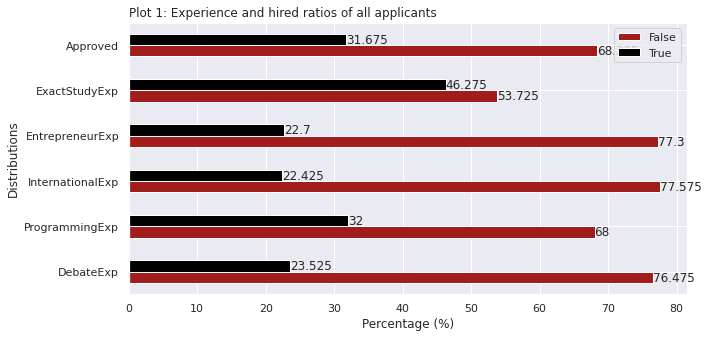

In [2]:
#Create data frame for the dichotomous features
dichotomousFrame = pd.DataFrame(recruitmentData, columns=['ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
                                                          'ind-entrepeneur_exp', 'ind-exact_study',  'decision'])

dichotomousFrame = dichotomousFrame.rename(columns={'ind-debateclub': 'DebateExp', 'ind-programming_exp': 'ProgrammingExp', 'ind-exact_study': 'ExactStudyExp',
                                                    'ind-international_exp': 'InternationalExp', 'ind-entrepeneur_exp': 'EntrepreneurExp', 'decision': 'Approved'})

#Dichotomous features plotting in percentages
dichotomousFrame = dichotomousFrame.apply(pd.value_counts).div(len(dichotomousFrame)).mul(100)
dichotomousFrameFlip = dichotomousFrame.transpose()
axis = dichotomousFrameFlip.plot.barh(figsize=(10,5), color={'#000000','#a31c1c'})
for container in axis.containers: axis.bar_label(container)

plt.title('Plot 1: Experience and hired ratios of all applicants',loc='left')
plt.xlabel('Percentage (%)')
plt.ylabel('Distributions')

Text(0.5, 0.98, 'Plot 2: Multichotomous qualitiy distributions of all applicants')

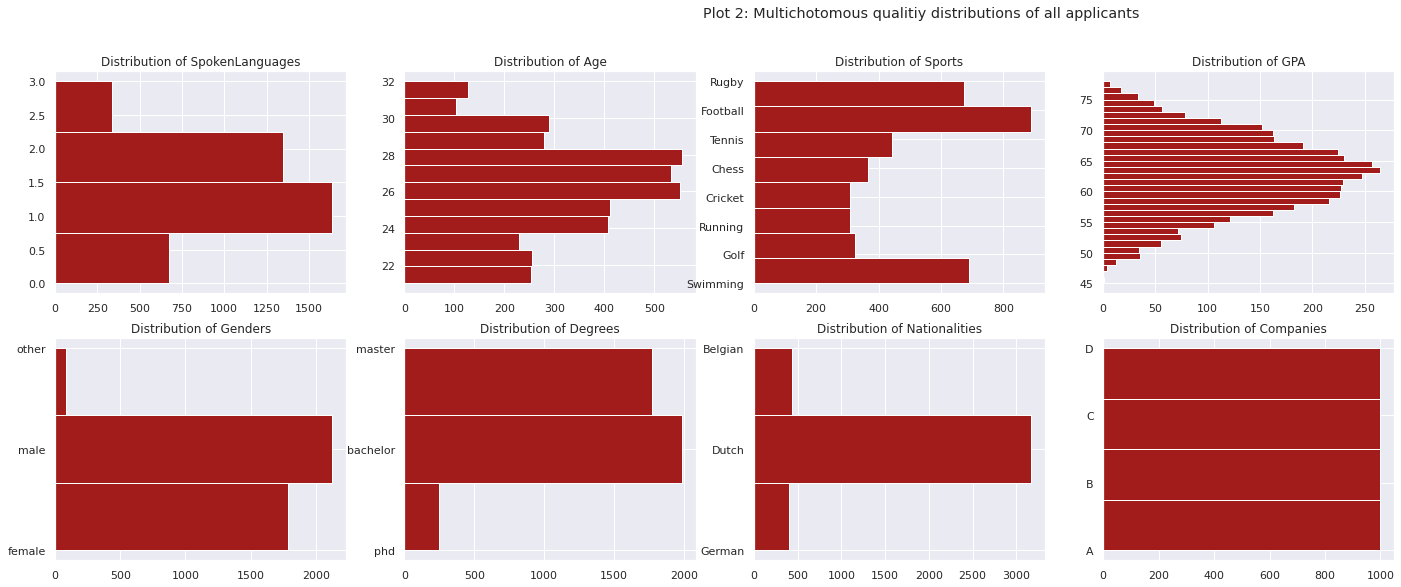

In [3]:
#Create data frame for the multichotomous features
multichotomousFrame = pd.DataFrame(recruitmentData, columns=['ind-languages', 'age', 'sport', 'ind-university_grade',
                                                             'gender', 'ind-degree', 'nationality',  'company'])
multichotomousFrame.columns = ['SpokenLanguages', 'Age', 'Sports', 'GPA', 'Genders', 'Degrees', 'Nationalities', 'Companies']

#Multichotomous features plotting
fig, axs = plt.subplots(2,4)
fig.set_figwidth(24)
fig.set_figheight(9)

for x in range(2):
    for y in range(4):
        column = multichotomousFrame.iloc[:, (x * 4 + y)]
        axs[x, y].set_title('Distribution of ' + column.name)
        axs[x, y].hist(column, bins = column.unique().size, align='mid', orientation='horizontal', color='#a31c1c')
fig.suptitle('Plot 2: Multichotomous qualitiy distributions of all applicants', horizontalalignment='left')

### 1.2 Visualisation of all hiree qualities for each company

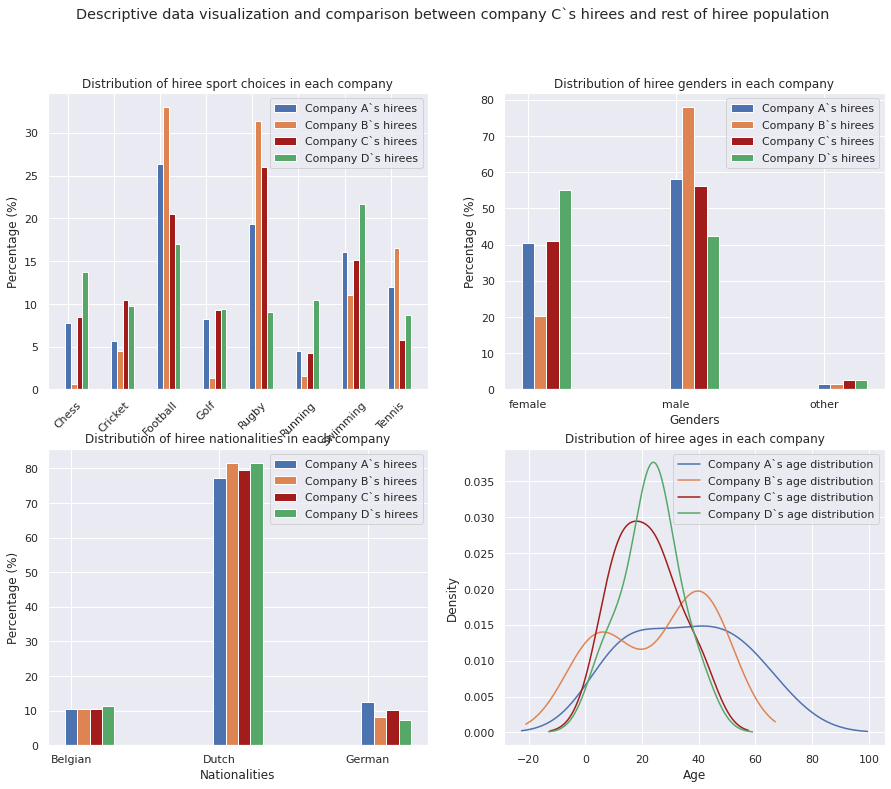

In [4]:
#Parameters used in plot creation
numberOfGenders = recruitmentData['gender'].unique().size
numberOfNationalities = recruitmentData['nationality'].unique().size
numberOfSports = recruitmentData['sport'].unique().size

fig, axs = plt.subplots(2,2)
fig.suptitle('Descriptive data visualization and comparison between company C`s hirees and rest of hiree population')
fig.set_figwidth(15)
fig.set_figheight(12)

#First Plot
XSportsAxis = np.arange(numberOfSports)

for idx, x in enumerate(recruitmentData['company'].unique()):
    sportFrame = recruitmentData.query("decision and company == '" + str(x) + "'")['sport']
    normalizedSportCounts = sportFrame.value_counts().sort_index().divide(sportFrame.count()).multiply(100)
    if (x == 'C'): axs[0, 0].bar(XSportsAxis + idx/numberOfSports, normalizedSportCounts, width= 1/numberOfSports, label='Company ' + str(x) + '`s hirees',color='#a31c1c')
    else: axs[0, 0].bar(XSportsAxis + idx/numberOfSports, normalizedSportCounts, width= 1/numberOfSports, label='Company ' + str(x) + '`s hirees')

axs[0, 0].set_xticks(XSportsAxis)
axs[0, 0].set_xticklabels(recruitmentData['sport'].sort_values().unique().tolist(), rotation=45)
axs[0, 0].set_xlabel('Sports')
axs[0, 0].set_ylabel('Percentage (%)')
axs[0, 0].set_title('Distribution of hiree sport choices in each company')
axs[0, 0].legend()

#Second Plot
XGendersAxis = np.arange(numberOfGenders)
for idx, x in enumerate(recruitmentData['company'].unique()):
    genderColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['gender']
    normalizedGenderCounts = genderColumn.value_counts().sort_index().divide(genderColumn.count()).multiply(100)
    if (x == 'C'): axs[0, 1].bar(XGendersAxis + idx/(numberOfGenders * 4), normalizedGenderCounts, width= 1/(numberOfGenders * 4), label='Company ' + str(x) + '`s hirees',color='#a31c1c')
    else: axs[0, 1].bar(XGendersAxis + idx/(numberOfGenders * 4), normalizedGenderCounts, width= 1/(numberOfGenders * 4), label='Company ' + str(x) + '`s hirees')

axs[0, 1].set_xticks(XGendersAxis)
axs[0, 1].set_xticklabels(recruitmentData['gender'].sort_values().unique().tolist())
axs[0, 1].set_xlabel('Genders')
axs[0, 1].set_ylabel('Percentage (%)')
axs[0, 1].set_title('Distribution of hiree genders in each company')
axs[0, 1].legend()

#Third Plot
XNationalitiesAxis = np.arange(numberOfNationalities)
for idx, x in enumerate(recruitmentData['company'].unique()):
    nationalityColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['nationality']
    normalizedNationalityCounts = nationalityColumn.value_counts().sort_index().divide(nationalityColumn.count()).multiply(100)
    if (x == 'C'): axs[1, 0].bar(XGendersAxis + idx/(numberOfNationalities * 4), normalizedNationalityCounts, width= 1/(numberOfNationalities * 4), label='Company ' + str(x) + '`s hirees',color='#a31c1c')
    else: axs[1, 0].bar(XGendersAxis + idx/(numberOfNationalities * 4), normalizedNationalityCounts, width= 1/(numberOfNationalities * 4), label='Company ' + str(x) + '`s hirees')

axs[1, 0].set_xticks(XNationalitiesAxis)
axs[1, 0].set_xticklabels(recruitmentData['nationality'].sort_values().unique().tolist())
axs[1, 0].set_xlabel('Nationalities')
axs[1, 0].set_ylabel('Percentage (%)')
axs[1, 0].set_title('Distribution of hiree nationalities in each company')
axs[1, 0].legend()

#Fourth Plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    ageColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['age']
    if (x == 'C'): axs[1, 1] = ageColumn.value_counts().plot(kind='density', label='Company ' + str(x) + '`s age distribution',color='#a31c1c')
    else: axs[1, 1] = ageColumn.value_counts().plot(kind='density', label='Company ' + str(x) + '`s age distribution')
axs[1, 1].set_xlabel('Age')
axs[1, 1].set_ylabel('Density')
axs[1, 1].set_title('Distribution of hiree ages in each company')
axs[1, 1].legend()


### 1.4 Hiree indicator data visualisation and analysis

We start of by visualising the ratios of all indicator data. Firstly, we will compare the distribution of indicators for hirees of company C and the rest of the hiree population:

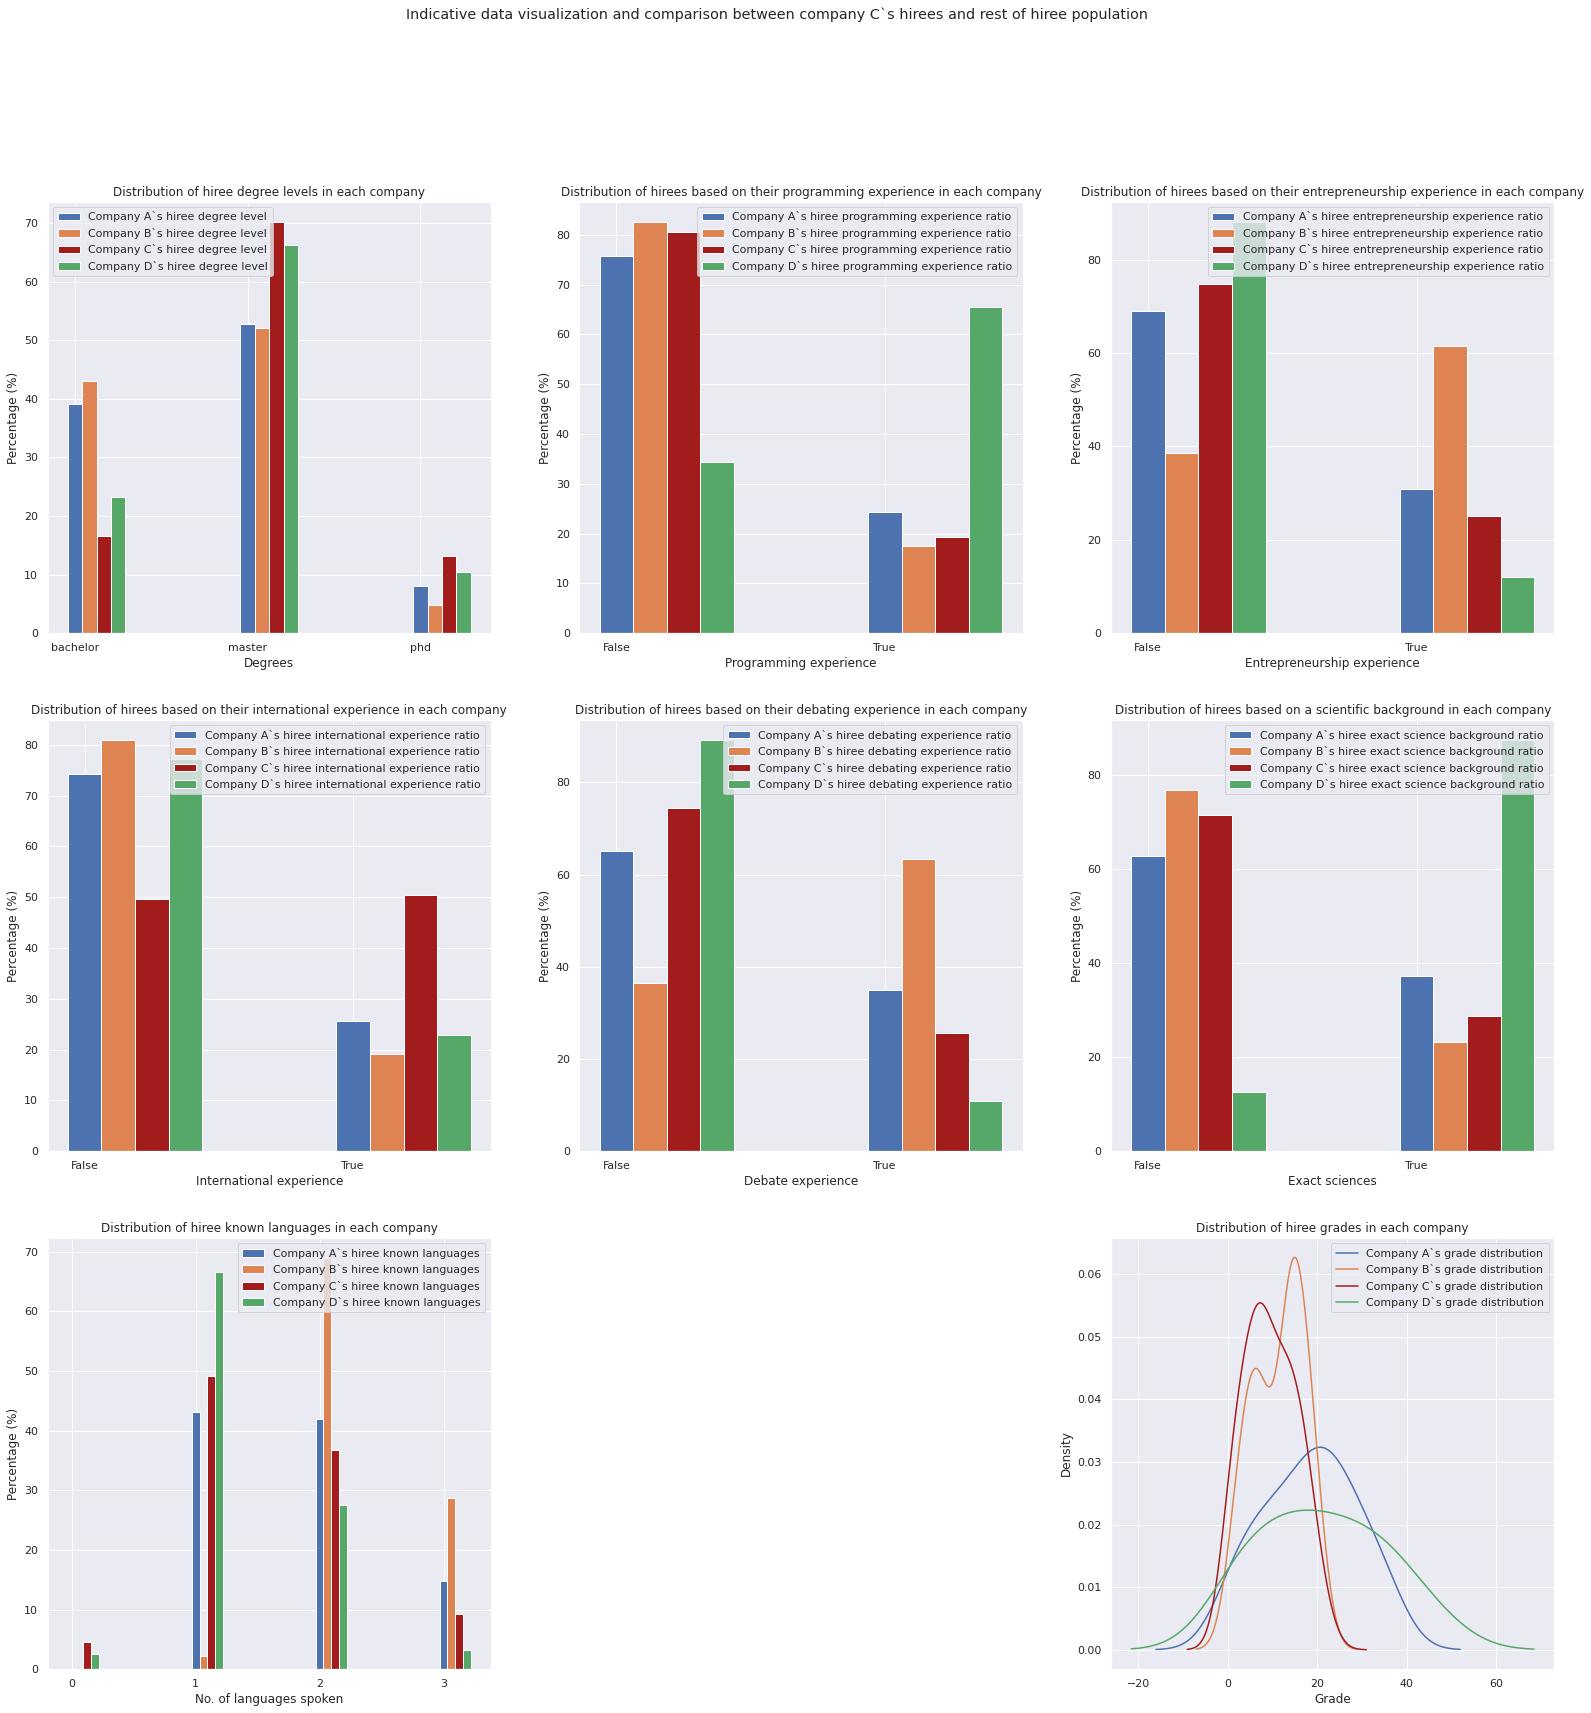

In [5]:
fig, axs = plt.subplots(3,3)
fig.suptitle('Indicative data visualization and comparison between company C`s hirees and rest of hiree population')
fig.set_figwidth(27)
fig.set_figheight(27)

#First plot
numberOfDegrees = recruitmentData['ind-degree'].unique().size
XDegreeAxis = np.arange(numberOfGenders)
for idx, x in enumerate(recruitmentData['company'].unique()):
    degreeColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-degree']
    normalizedDegreeCounts = degreeColumn.value_counts().sort_index().divide(degreeColumn.count()).multiply(100)
    if (x == 'C'): axs[0, 0].bar(XDegreeAxis + idx/(numberOfDegrees * 4), normalizedDegreeCounts, width= 1/(numberOfDegrees * 4), label='Company ' + str(x) + '`s hiree degree level',color='#a31c1c')
    else: axs[0, 0].bar(XDegreeAxis + idx/(numberOfDegrees * 4), normalizedDegreeCounts, width= 1/(numberOfDegrees * 4), label='Company ' + str(x) + '`s hiree degree level')

axs[0, 0].set_xticks(XDegreeAxis)
axs[0, 0].set_xticklabels(recruitmentData['ind-degree'].sort_values().unique().tolist())
axs[0, 0].set_xlabel('Degrees')
axs[0, 0].set_ylabel('Percentage (%)')
axs[0, 0].set_title('Distribution of hiree degree levels in each company')
axs[0, 0].legend()

#Second plot
XBooleanAxis = np.arange(2)
for idx, x in enumerate(recruitmentData['company'].unique()):
    progColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-programming_exp']
    normalizedProgCounts = progColumn.value_counts().sort_index().divide(progColumn.count()).multiply(100)
    if (x == 'C'): axs[0, 1].bar(XBooleanAxis + idx/8, normalizedProgCounts, width= 1/8, label='Company ' + str(x) + '`s hiree programming experience ratio',color='#a31c1c')
    else: axs[0, 1].bar(XBooleanAxis + idx/8, normalizedProgCounts, width= 1/8, label='Company ' + str(x) + '`s hiree programming experience ratio')

axs[0, 1].set_xticks(XBooleanAxis)
axs[0, 1].set_xticklabels(recruitmentData['ind-programming_exp'].sort_values().unique().tolist())
axs[0, 1].set_xlabel('Programming experience')
axs[0, 1].set_ylabel('Percentage (%)')
axs[0, 1].set_title('Distribution of hirees based on their programming experience in each company')
axs[0, 1].legend()

#Third plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    entrepreneurColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-entrepeneur_exp']
    normalizedEntrCounts = entrepreneurColumn.value_counts().sort_index().divide(entrepreneurColumn.count()).multiply(100)
    if (x == 'C'): axs[0, 2].bar(XBooleanAxis + idx/8, normalizedEntrCounts, width= 1/8, label='Company ' + str(x) + '`s hiree entrepreneurship experience ratio', color='#a31c1c')
    else: axs[0, 2].bar(XBooleanAxis + idx/8, normalizedEntrCounts, width= 1/8, label='Company ' + str(x) + '`s hiree entrepreneurship experience ratio')

axs[0, 2].set_xticks(XBooleanAxis)
axs[0, 2].set_xticklabels(recruitmentData['ind-entrepeneur_exp'].sort_values().unique().tolist())
axs[0, 2].set_xlabel('Entrepreneurship experience')
axs[0, 2].set_ylabel('Percentage (%)')
axs[0, 2].set_title('Distribution of hirees based on their entrepreneurship experience in each company')
axs[0, 2].legend()

#Fourth plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    internationalColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-international_exp']
    normalizedInterCounts = internationalColumn.value_counts().sort_index().divide(internationalColumn.count()).multiply(100)
    if (x == 'C'): axs[1, 0].bar(XBooleanAxis + idx/8, normalizedInterCounts, width= 1/8, label='Company ' + str(x) + '`s hiree international experience ratio', color='#a31c1c')
    else: axs[1, 0].bar(XBooleanAxis + idx/8, normalizedInterCounts, width= 1/8, label='Company ' + str(x) + '`s hiree international experience ratio')

axs[1, 0].set_xticks(XBooleanAxis)
axs[1, 0].set_xticklabels(recruitmentData['ind-international_exp'].sort_values().unique().tolist())
axs[1, 0].set_xlabel('International experience')
axs[1, 0].set_ylabel('Percentage (%)')
axs[1, 0].set_title('Distribution of hirees based on their international experience in each company')
axs[1, 0].legend()

#Fifth plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    debateColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-debateclub']
    normalizedDebateCounts = debateColumn.value_counts().sort_index().divide(debateColumn.count()).multiply(100)
    if (x == 'C'): axs[1, 1].bar(XBooleanAxis + idx/8, normalizedDebateCounts, width= 1/8, label='Company ' + str(x) + '`s hiree debating experience ratio', color='#a31c1c')
    else: axs[1, 1].bar(XBooleanAxis + idx/8, normalizedDebateCounts, width= 1/8, label='Company ' + str(x) + '`s hiree debating experience ratio')

axs[1, 1].set_xticks(XBooleanAxis)
axs[1, 1].set_xticklabels(recruitmentData['ind-debateclub'].sort_values().unique().tolist())
axs[1, 1].set_xlabel('Debate experience')
axs[1, 1].set_ylabel('Percentage (%)')
axs[1, 1].set_title('Distribution of hirees based on their debating experience in each company')
axs[1, 1].legend()

#Sixth plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    debateColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-exact_study']
    normalizedDebateCounts = debateColumn.value_counts().sort_index().divide(debateColumn.count()).multiply(100)
    if (x == 'C'): axs[1, 2].bar(XBooleanAxis + idx/8, normalizedDebateCounts, width= 1/8, label='Company ' + str(x) + '`s hiree exact science background ratio', color='#a31c1c')
    else: axs[1, 2].bar(XBooleanAxis + idx/8, normalizedDebateCounts, width= 1/8, label='Company ' + str(x) + '`s hiree exact science background ratio')

axs[1, 2].set_xticks(XBooleanAxis)
axs[1, 2].set_xticklabels(recruitmentData['ind-exact_study'].sort_values().unique().tolist())
axs[1, 2].set_xlabel('Exact sciences')
axs[1, 2].set_ylabel('Percentage (%)')
axs[1, 2].set_title('Distribution of hirees based on a scientific background in each company')
axs[1, 2].legend()

#Seventh plot
numberOfLanguages = recruitmentData['ind-languages'].unique().size
XLanguagesAxis = np.arange(0,numberOfLanguages)
for idx, x in enumerate(recruitmentData['company'].unique()):
    languageColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-languages']
    normalizedLanguageCounts = languageColumn.value_counts().sort_index().divide(languageColumn.count()).multiply(100)
    if(normalizedLanguageCounts.index[0] != 0): normalizedLanguageCounts = pd.Series([0]).append(normalizedLanguageCounts)
    if (x == 'C'): axs[2, 0].bar(XLanguagesAxis + idx/(numberOfLanguages*4), normalizedLanguageCounts, width= 1/(numberOfLanguages * 4), label='Company ' + str(x) + '`s hiree known languages', color='#a31c1c')
    else: axs[2, 0].bar(XLanguagesAxis + idx/(numberOfLanguages*4), normalizedLanguageCounts, width= 1/(numberOfLanguages * 4), label='Company ' + str(x) + '`s hiree known languages')

axs[2, 0].set_xticks(XLanguagesAxis)
axs[2, 0].set_xticklabels(recruitmentData['ind-languages'].sort_values().unique().tolist())
axs[2, 0].set_xlabel('No. of languages spoken')
axs[2, 0].set_ylabel('Percentage (%)')
axs[2, 0].set_title('Distribution of hiree known languages in each company')
axs[2, 0].legend()

axs[2, 1].set_visible(False)

#Eigth plot
for idx, x in enumerate(recruitmentData['company'].unique()):
    gradeColumn = recruitmentData.query("decision and company == '" + str(x) + "'")['ind-university_grade']
    if (x == 'C'): axs[2, 2] = gradeColumn.value_counts().plot(kind='density', label='Company ' + str(x) + '`s grade distribution', color='#a31c1c')
    else: axs[2, 2] = gradeColumn.value_counts().plot(kind='density', label='Company ' + str(x) + '`s grade distribution')
axs[2, 2].set_xlabel('Grade')
axs[2, 2].set_ylabel('Density')
axs[2, 2].set_title('Distribution of hiree grades in each company')
axs[2, 2].legend()

#### Indicator analysis based on the plots above:

- In the first graph we can observe that for our company, the majority of the hirees have finished a masters degree (70% of the candidates) but this is the case for all the other companies as well.

- Based on the second, third, fifth and sixth graphs we can conclude that the majority of company C's hirees do not have any programming experience, any entrepreneurship experience, any debate experience and the majority also does not come from a scientific background.

- One thing to note (based on the fourth graph) is that the hirees of our company are evenly distributed between people that have had international experience and people that did not.

- Based on the eigth graph we can conclude that our company's hirees know around 2-3 other languages.

- Lastly, in terms of university grades, we can observe that the hirees of our company have an average of scores close to 62/100 with the maximum grade achieved being 77/100 and the lowest grade being 51/100.

### 1.3 Data cleaning and preparation as well as evaluating highest correlating parameters

In this section we will evaluate the features that we have visualized in the plotting above, make some assumptions and test them in terms of data meaningfulness.
These assumption will be used when building a model in the hopes of achieving a fair discrete alternative to our categorical data.

     ind-university_grade  ind-debateclub  ind-programming_exp  \
0               -0.237259        1.785961            -0.694051   
1               -0.237259       -0.559923             1.440816   
2               -1.080154       -0.559923            -0.694051   
3                1.617108       -0.559923             1.440816   
4               -1.080154       -0.559923            -0.694051   
..                    ...             ...                  ...   
967              2.291424       -0.559923             1.440816   
968              0.437056       -0.559923            -0.694051   
969             -0.574417        1.785961            -0.694051   
970              1.279951       -0.559923             1.440816   
971             -2.260206        1.785961            -0.694051   

     ind-international_exp  ind-entrepeneur_exp  ind-languages  \
0                -0.518584            -0.559923       0.776463   
1                -0.518584            -0.559923      -0.390032   
2        

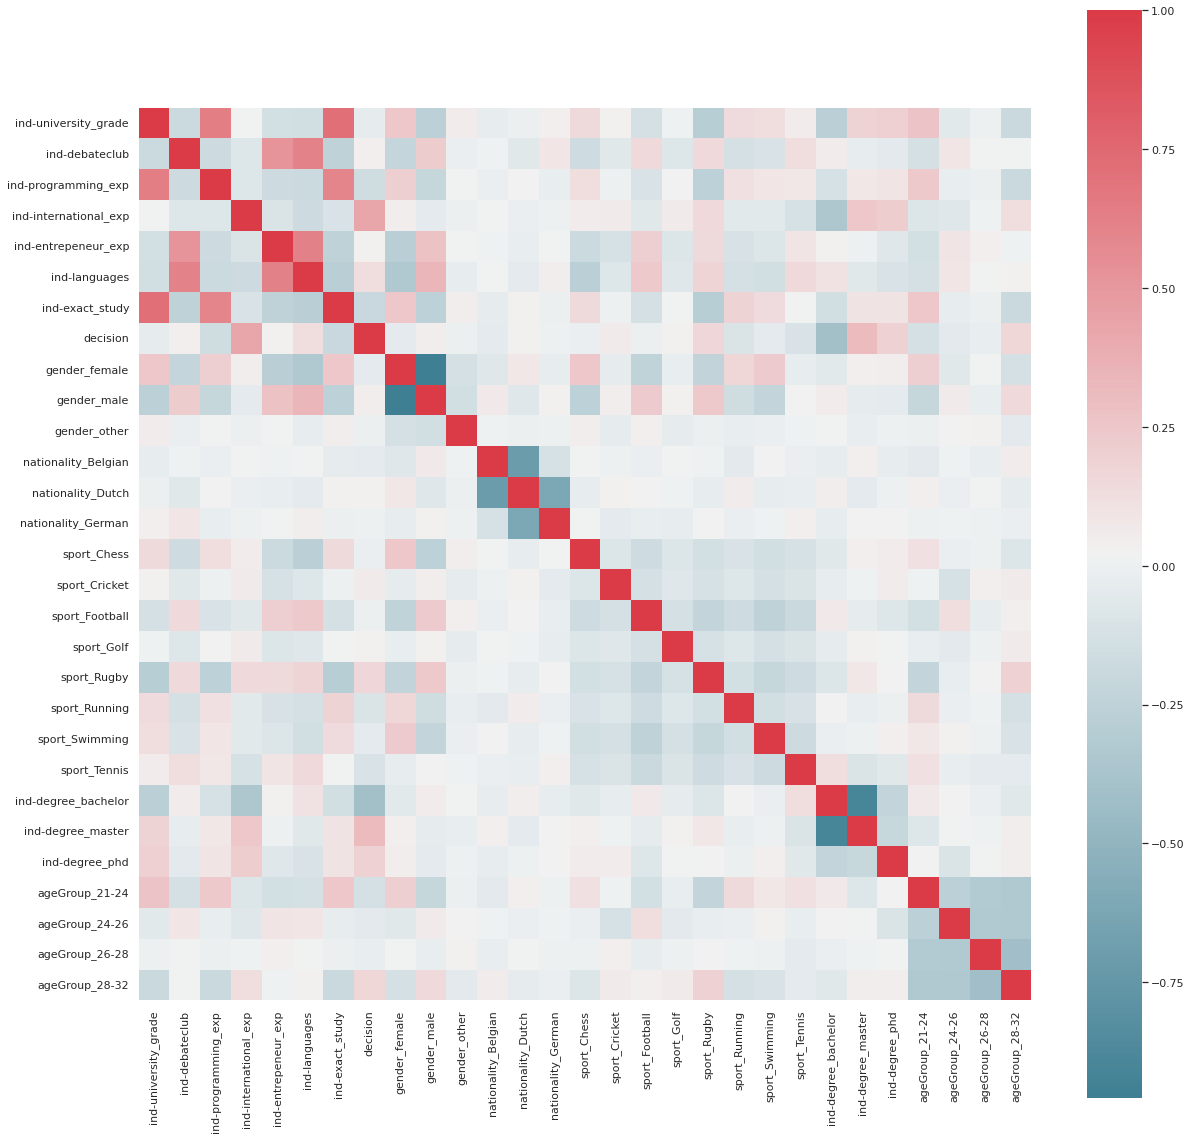

ind-degree_bachelor     -0.400664
ind-exact_study         -0.194853
ind-programming_exp     -0.157908
ageGroup_21-24          -0.126317
sport_Tennis            -0.105529
sport_Running           -0.093571
ageGroup_24-26          -0.048269
sport_Swimming          -0.047090
gender_female           -0.046666
nationality_Belgian     -0.043310
ind-university_grade    -0.038893
ageGroup_26-28          -0.017746
sport_Chess             -0.011129
gender_other            -0.005468
sport_Football          -0.002011
nationality_German       0.005016
nationality_Dutch        0.030801
sport_Golf               0.032944
ind-entrepeneur_exp      0.033512
ind-debateclub           0.039056
gender_male              0.048142
sport_Cricket            0.061324
ind-languages            0.130695
sport_Rugby              0.161489
ageGroup_28-32           0.172023
ind-degree_phd           0.194166
ind-degree_master        0.318404
ind-international_exp    0.425880
decision                 1.000000
Name: Ranking 

In [6]:
#Focus the dataset to our company
dataSet = recruitmentData.query("company == 'C'")
dataSetC = pd.DataFrame(dataSet, columns=[
    'age',
    'gender',
    'nationality',
    'sport',
    'ind-university_grade',
    'ind-debateclub',
    'ind-programming_exp',
    'ind-international_exp',
    'ind-entrepeneur_exp',
    'ind-languages',
    'ind-exact_study',
    'ind-degree',
    'decision'
])

labelEncoder = LabelEncoder()

# Convert the following numerical labels from interger to float
conversions = {
    'ind-languages' : float,
    'ind-university_grade' : float
}
dataSetC = dataSetC.astype(conversions)

#Transoform age into age groups depending on the general distribution of ages in the dataset
bins= recruitmentData['age'].describe()[3:8]
labels = ['21-24','24-26','26-28','28-32']
dataSetC['ageGroup'] = pd.cut(dataSetC['age'], bins=bins, labels=labels, right=False)
dataSetC = dataSetC.drop('age', axis=1)
dataSetC = dataSetC.dropna()
    
# Label Encoder conversion
dataSetC['decision'] = labelEncoder.fit_transform(dataSetC['decision'])
dataSetC['ind-debateclub'] = labelEncoder.fit_transform(dataSetC['ind-debateclub'])
dataSetC['ind-entrepeneur_exp'] = labelEncoder.fit_transform(dataSetC['ind-entrepeneur_exp'])
dataSetC['ind-exact_study'] = labelEncoder.fit_transform(dataSetC['ind-exact_study'])
dataSetC['ind-programming_exp'] = labelEncoder.fit_transform(dataSetC['ind-programming_exp'])
dataSetC['ind-international_exp'] = labelEncoder.fit_transform(dataSetC['ind-international_exp'])    

# One Hot Encoding conversion for gender, sport, agegroups and degree
dataSetC = pd.get_dummies(dataSetC)

tmp = dataSetC['decision']
# Scale our data 
scaler = StandardScaler()
dataSetCNew = pd.DataFrame(scaler.fit_transform(dataSetC), columns= dataSetC.columns)
dataSetCNew['decision'] = tmp.values

print(dataSetCNew)
# Evaluating correlations in order to potentially find good combinations of features
corr = dataSetCNew.corr()
plt.figure(figsize=(20,20))
seaborn.heatmap(corr, mask=np.zeros_like(corr), cmap=seaborn.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()            
ranking = corr['decision']
ranking = ranking.sort_values()
ranking.name = "Ranking of the predictive power of indicators"
print(ranking)

print(dataSetCNew)


## 2. Models

In [7]:
#Result storage for each model for plotting
modelResults = pd.DataFrame(columns=['model','fit_time','score_time','test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'features'])

### 2.1 Model 1: Neural Network with single hidden layer and no drop-out

In [8]:
# prepare configuration for cross validation test harness
from scikeras.wrappers import KerasClassifier
from keras.callbacks import CSVLogger
from sklearn.metrics import get_scorer_names

results = pd.DataFrame(columns=['model','fit_time','score_time','test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'features'])
models = []
inputChoices = [pd.DataFrame(dataSetCNew, columns=['ind-languages', 'ind-degree_phd', 'ind-degree_master', 'ind-international_exp']),
				dataSetCNew.filter(like='ind').sample(n=4,axis='columns'),
				dataSetCNew.filter(like='ind').sample(n=3,axis='columns'),
				dataSetCNew.filter(like='ind').sample(n=5,axis='columns')]
target = dataSetC['decision']

#Setting hyperparameters and evaluation outputs
seed = 7
splits = 10
epochs = 50
scores = ['accuracy', 'precision_micro', 'recall', 'f1']

# Clear epoch data for new run if it's been ran before
f = open("epochAnalysisM1.csv", "w")
f.truncate()
f.close()

#Training model for each input variation
for idx, input in enumerate(inputChoices):	

	kfold = model_selection.KFold(n_splits=splits, random_state=seed, shuffle=True)
	model = Sequential()

	dataLogger = CSVLogger('epochAnalysisM1.csv', separator=",", append=True)
	
	#input layer
	model.add(Dense(6, kernel_initializer='uniform', activation = 'relu', input_dim = input.columns.size))

	#output layer
	model.add(Dense(1, kernel_initializer='uniform', activation = 'sigmoid'))
	#run model M1
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	keras_clf = KerasClassifier(model = model, optimizer="adam", epochs=epochs, verbose=0, callbacks=[dataLogger])

	cv_results = model_selection.cross_validate(keras_clf, input, target, cv=kfold, scoring=scores)
	

	#Saving dataFrame of epoch based results for plotting
	new_row = {'model': 'M1', 
			'fit_time' : cv_results['fit_time'].mean(),
			'score_time' : cv_results['score_time'].mean(),
			'test_accuracy' : cv_results['test_accuracy'].mean(),
			'test_precision' : cv_results['test_precision_micro'].mean(),
			'test_recall' : cv_results['test_recall'].mean(),
			'test_f1' : cv_results['test_f1'].mean(),
			'features' : ', '.join(input.columns)}
	results = results.append(new_row, ignore_index=True)

modelResults = modelResults.append(results.iloc[0].transpose(), ignore_index=True)
print(results)

2022-10-24 22:29:24.773919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-24 22:29:24.773954: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-24 22:29:24.773972: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (andrei-G531GU): /proc/driver/nvidia/version does not exist
2022-10-24 22:29:24.774165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpi1pjo_r4/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpusithxqo/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpnsmm0m_r/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpxgwkvbck/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp_0eb8mli/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmptkd3m0_i/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp29xi4ln5/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpoi8l20ek/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpvlzyyjwp/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpfuv9rqz7/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpq_pcm5ai/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpg0mbyusp/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpx4bl0r7z/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp14eovcfs/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp7j1ucl78/assets
INFO:tensorflow:Assets wr

#### Plotting model outputs

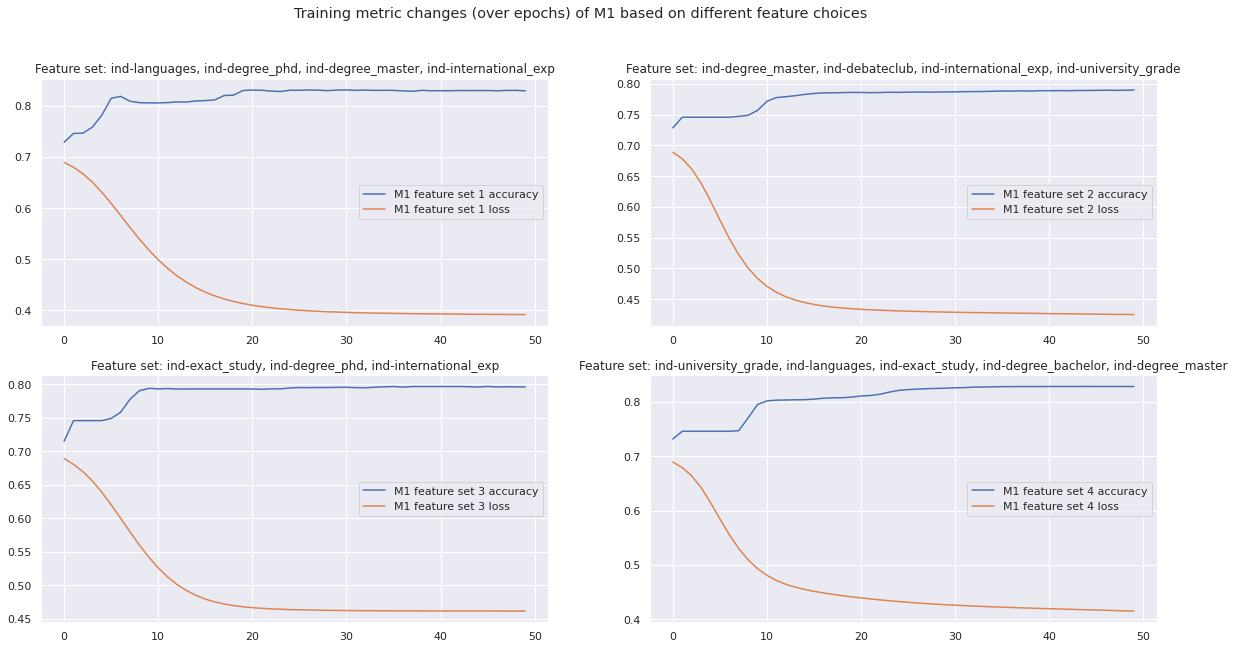

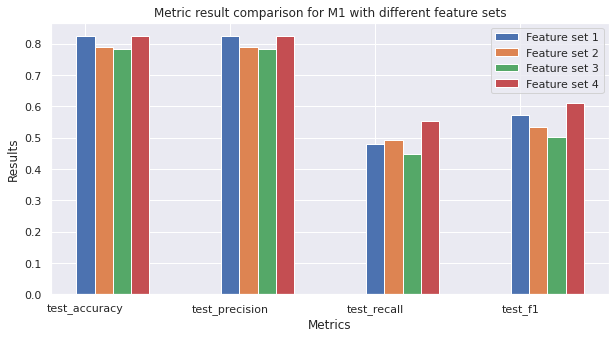

0    ind-languages, ind-degree_phd, ind-degree_mast...
1    ind-degree_master, ind-debateclub, ind-interna...
2    ind-exact_study, ind-degree_phd, ind-internati...
3    ind-university_grade, ind-languages, ind-exact...
Name: features, dtype: object


In [9]:
#Setting up figure for result plotting
fig, axs = plt.subplots(2,2)
axs = axs.ravel()
fig.suptitle('Training metric changes (over epochs) of M1 based on different feature choices')
fig.set_figwidth(20)
fig.set_figheight(10)


#Plotting epoch accuracy and loss
epochData = pd.read_csv (r'epochAnalysisM1.csv')
sectionStart = 0

for index in range(0, len(inputChoices), 1):
    #Select the logs only of one set of inputs
    sectionOfInterest = epochData.loc[(index * epochs * splits):((index + 1) * epochs * splits)]

    #Prepare container for data compression
    averagedFrame = pd.DataFrame(columns=epochData.columns)
    for idx, epoch in enumerate(sectionOfInterest['epoch'].unique()):
        oneEpoch = sectionOfInterest.query('epoch == %i' % epoch)
        averagedFrame = averagedFrame.append({'epoch' : epoch,
                                            'accuracy' : oneEpoch['accuracy'].mean(),
                                            'loss' : oneEpoch['loss'].mean()
                                            }, ignore_index=True)
    
    axs[index].set_title('Feature set: %s' % ', '.join(inputChoices[index].columns))
    axs[index].plot(averagedFrame['accuracy'], label='M1 feature set %i accuracy' % (index + 1))
    axs[index].plot(averagedFrame['loss'], label='M1 feature set %i loss' % (index + 1))
    axs[index].legend()

plt.show()

#Plotting results from each model input
interestData = results.drop(['model', 'fit_time', 'score_time', 'features'], axis=1)
XResultsAxis = np.arange(len(interestData.columns))
interestData = interestData.transpose()

fig, axs = plt.subplots(1,1)
fig.set_figwidth(10)
fig.set_figheight(5)

for idx, x in enumerate(results['model']):
    axis = axs.bar(XResultsAxis + idx/(len(interestData.columns) * 2), interestData[idx].values, width= 1/(len(interestData.columns) * 2), label='Feature set %i' % (idx + 1))
    
axs.set_xticks(XResultsAxis)
axs.set_xticklabels(results.drop(['model', 'fit_time', 'score_time', 'features'], axis=1).columns)
axs.set_xlabel('Metrics')
axs.set_ylabel('Results')
axs.set_title('Metric result comparison for M1 with different feature sets')
axs.legend()
plt.show()

print(results['features'])

### 2.2 Model 2: Decision Tree Classifier

Model accuracy score : 0.8513
Precision score (weighted): 0.7670830824804336
Recall score (weighted): 0.7916666666666667
F1 score (weighted): 0.7780699344609711
  model  fit_time  score_time  test_accuracy  test_precision  test_recall  \
0    M1   1.44107    0.066769       0.823059        0.823059     0.480732   
1    M2   0.00000    0.000000       0.851282        0.767083     0.791667   

    test_f1                                           features  
0  0.572689  ind-languages, ind-degree_phd, ind-degree_mast...  
1  0.778070  ind-degree_master, ind-international_exp, ind-...  


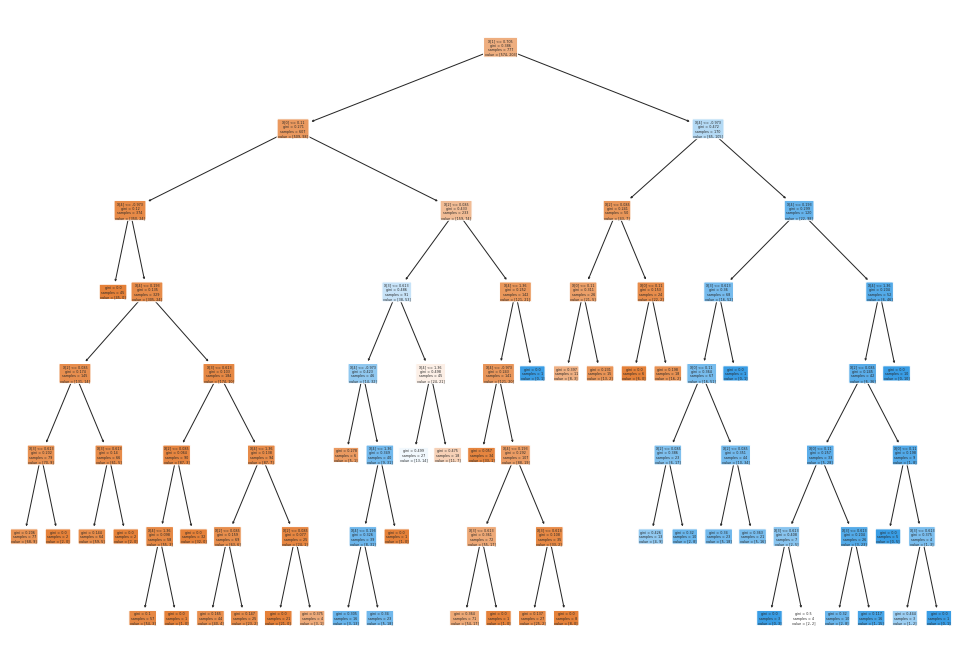

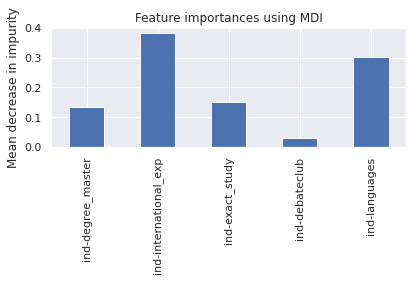

In [10]:
features_to_model = [ 'ind-degree_master', 'ind-international_exp',
                      'ind-exact_study', 'ind-debateclub' , 'ind-languages' ]
dataInScope = pd.DataFrame(dataSetCNew, columns=features_to_model)

x = pd.DataFrame(dataInScope.values)
y = dataSetC['decision'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

clf = tree.DecisionTreeClassifier()
decision_tree = clf.fit(x_train, y_train)

#visualize tree
plt.subplots(figsize=(17, 12))
tree.plot_tree(decision_tree, filled=True, rounded=True)
plt.savefig("decision_tree.png")

#importance of feaures
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index = features_to_model)
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#accuracy and precision
y_pred = clf.predict(x_test)
print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
precision_recall = precision_recall_fscore_support(y_pred, y_test, average= 'macro')
print('Precision score (weighted):', precision_recall[0])
print('Recall score (weighted):', precision_recall[1])
f1 = f1_score(y_test, y_pred, average='macro')
print('F1 score (weighted):', f1)

#Saving dataFrame of epoch based results for plotting
new_row = {'model': 'M2', 
			'fit_time' : 0,
			'score_time' : 0,
			'test_accuracy' : accuracy_score(y_test, y_pred),
			'test_precision' : precision_recall[0],
			'test_recall' : precision_recall[1],
			'test_f1' : f1,
			'features' : ', '.join(features_to_model)}
	

modelResults = modelResults.append(new_row, ignore_index=True)
print(modelResults)

#### Plotting model outputs

### 2.3 Model 3: Neural Network with single hidden layer and no drop-out on descriptors

In [19]:
# prepare configuration for cross validation test harness
from scikeras.wrappers import KerasClassifier
from keras.callbacks import CSVLogger

results = pd.DataFrame(columns=['model','fit_time','score_time','test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'features'])
models = []



inputChoices = [pd.DataFrame(dataSetCNew, columns=['sport_Tennis', 
												'sport_Running', 
												'sport_Swimming', 
												'sport_Chess',
												'sport_Football',
												'sport_Golf',
												'sport_Cricket',
												'sport_Rugby',
												'gender_female',
												'gender_other',
												'gender_male',
												'nationality_German',
												'nationality_Dutch',
												'nationality_Belgian',
												'ageGroup_21-24',
												'ageGroup_24-26',
												'ageGroup_26-28',
												'ageGroup_28-32'])
				]

target = dataSetC['decision']

#Setting hyperparameters and evaluation outputs
seed = 7
splits = 10
epochs = 50
scores = ['accuracy', 'precision', 'recall', 'f1']

# Clear epoch data for new run if it's been ran before
f = open("epochAnalysisM2.csv", "w")
f.truncate()
f.close()

#Training model for each input variation
for idx, input in enumerate(inputChoices):	

	kfold = model_selection.KFold(n_splits=splits, random_state=seed, shuffle=True)
	model = Sequential()
	dataLogger = CSVLogger('epochAnalysisM2.csv', separator=",", append=True)
	#input layer
	model.add(Dense(6, kernel_initializer='uniform', activation = 'relu', input_dim = input.columns.size))

	#output layer
	model.add(Dense(1, kernel_initializer='uniform', activation = 'sigmoid'))

	#run model M1
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],run_eagerly=True)
	keras_clf = KerasClassifier(model = model, optimizer="adam", epochs=epochs, verbose=0, callbacks=[dataLogger])
	cv_results = model_selection.cross_validate(keras_clf, input, target, cv=kfold, scoring=scores)

	#Saving dataFrame of epoch based results for plotting
	new_row = {'model': 'M3', 
			'fit_time' : cv_results['fit_time'].mean(),
			'score_time' : cv_results['score_time'].mean(),
			'test_accuracy' : cv_results['test_accuracy'].mean(),
			'test_precision' : cv_results['test_precision'].mean(),
			'test_recall' : cv_results['test_recall'].mean(),
			'test_f1' : cv_results['test_f1'].mean(),
			'features' : ', '.join(input.columns)}
	results = results.append(new_row, ignore_index=True)

modelResults = modelResults.append(results, ignore_index=True)
print(results)

INFO:tensorflow:Assets written to: ram:///tmp/tmpv69e7ern/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpoxdjf80u/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpimcfgm67/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpml3_rrnw/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpyoi0l44n/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpoj53ajr6/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp7_lhbzn6/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpf2d2lmvo/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpat5838f_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpf2m2gsjw/assets
  model  fit_time  score_time  test_accuracy  test_precision  test_recall  \
0     1  1.587401    0.066053       0.744919        0.592857     0.078203   

    test_f1                                           features  
0  0.132531  sport_Tennis, sport_Running, sport_Swimming, s...  


#### Plotting of Model 3 metrics using all descriptive data

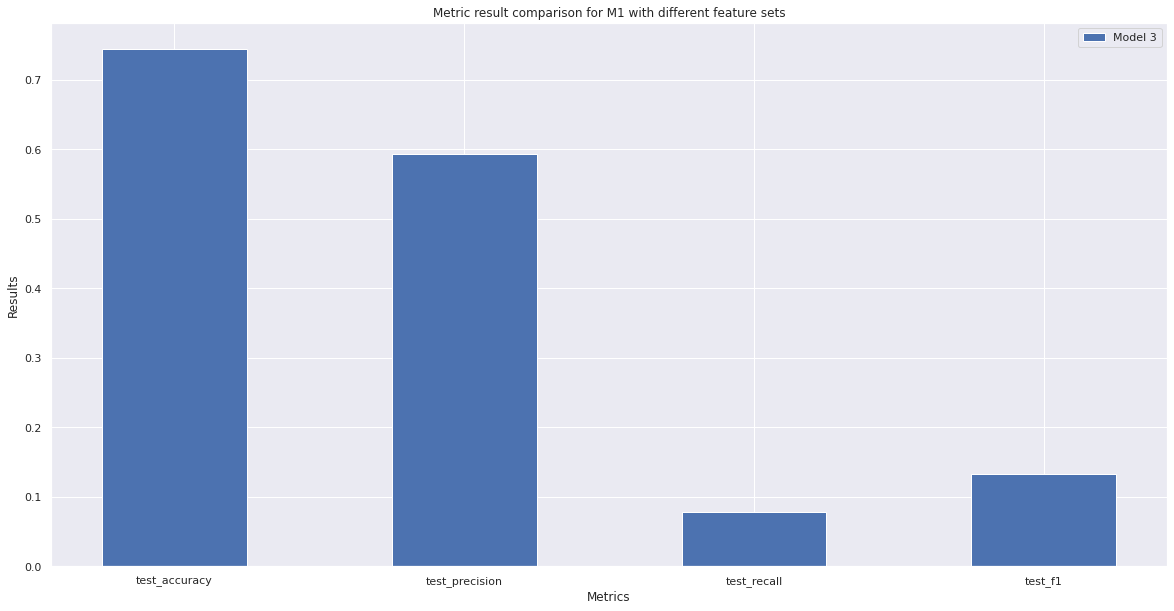

0    sport_Tennis, sport_Running, sport_Swimming, s...
Name: features, dtype: object


In [20]:
interestData = results.drop(['model', 'fit_time', 'score_time', 'features'], axis=1)
XResultsAxis = np.arange(len(interestData.columns))
interestData = interestData.transpose()

fig, axs = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(10)
axis = axs.bar(XResultsAxis + idx/(len(interestData.columns) * 2), interestData[idx].values, width= 1/(len(interestData.columns) * 2), label='Model 3')
axs.set_xticks(XResultsAxis)
axs.set_xticklabels(results.drop(['model', 'fit_time', 'score_time', 'features'], axis=1).columns)
axs.set_xlabel('Metrics')
axs.set_ylabel('Results')
axs.set_title('Metric result comparison for M1 with different feature sets')
axs.legend()
plt.show()

print(results['features'])

#### Plotting of Model 3 metrics for different subgroups

2/2 [==============================] - 0s 2ms/step


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-

4/4 [==============================] - 0s 2ms/step


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 0s 2ms/step


/home/andrei/usr/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


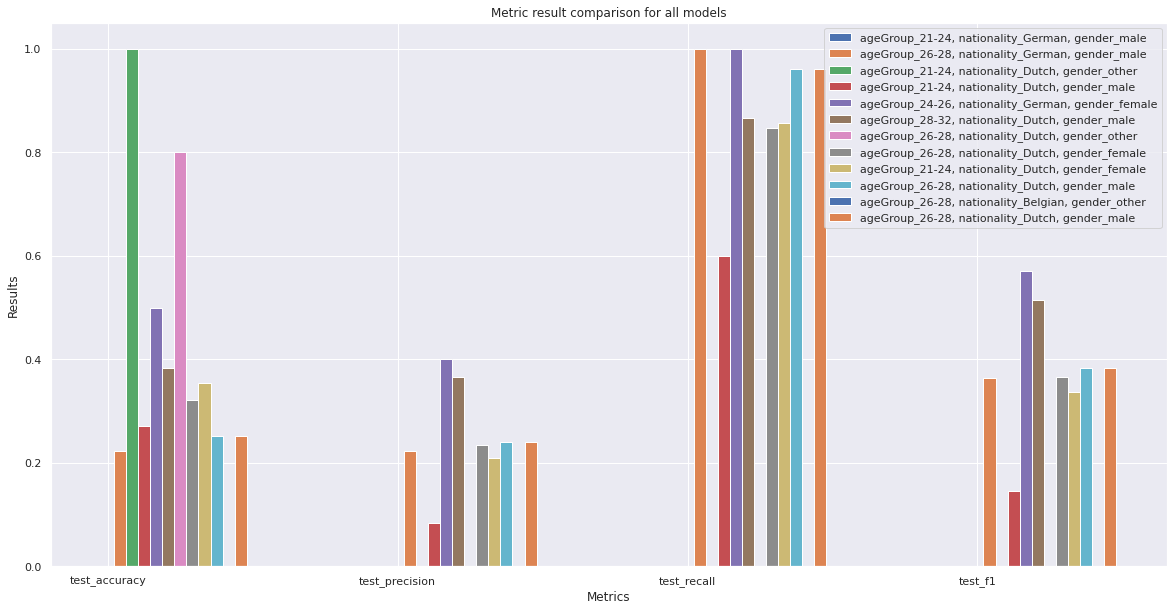

In [24]:
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Options for each descriptor
ageColumns = ['ageGroup_21-24', 'ageGroup_24-26', 'ageGroup_26-28', 'ageGroup_28-32']
nationalityColumns = ['nationality_German', 'nationality_Dutch', 'nationality_Belgian']
genderColumns = ['gender_female', 'gender_other', 'gender_male']

metrics = pd.DataFrame(columns=['model', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'features'])

#Selecting a random combination of 3 descriptive features, 12 times
x = 0
while x < 12:
	choices = [random.choice(ageColumns), random.choice(nationalityColumns), random.choice(genderColumns)]
	query = "`%s` > 0 and `%s` > 0 and `%s` > 0" % (choices[0], choices[1], choices[2])
	tmpInput = inputChoices[0].query(query)
	
	#If the queried combination has no inputs, we skip it
	if len(tmpInput) != 0:
		x_pred = tmpInput
		y_test = dataSetCNew.query(query)['decision']
		y_pred = model.predict(x_pred)

		#Take all scores from the prediction
		new_row = {'model': 'M3', 
				'test_accuracy' : accuracy_score(y_test.values,list(map(lambda x: 0 if x<0.5 else 1, y_pred))),
				'test_precision' : precision_score(y_test.values,list(map(lambda x: 0 if x<0.5 else 1, y_pred))),
				'test_recall' : recall_score(y_test.values,list(map(lambda x: 0 if x<0.5 else 1, y_pred))),
				'test_f1' : f1_score(y_test.values,list(map(lambda x: 0 if x<0.5 else 1, y_pred))),
				'features' : ', '.join(choices)}
		metrics = metrics.append(new_row, ignore_index=True)
		x += 1

#Plotting results from each model input
interestData = metrics.drop(['model', 'features'], axis=1)
XResultsAxis = np.arange(len(interestData.columns))
interestData = interestData.transpose()

fig, axs = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(10)

for idx, x in enumerate(metrics['model']):
    axis = axs.bar(XResultsAxis + idx/(len(interestData.columns) * 2), interestData[idx].values, width= 1/(len(interestData.columns) * 2), label=metrics['features'][idx])
    
axs.set_xticks(XResultsAxis)
axs.set_xticklabels(results.drop(['model', 'fit_time', 'score_time', 'features'], axis=1).columns)
axs.set_xlabel('Metrics')
axs.set_ylabel('Results')
axs.set_title('Metric result comparison for all models')
axs.legend()
plt.show()

# print(metrics)

	

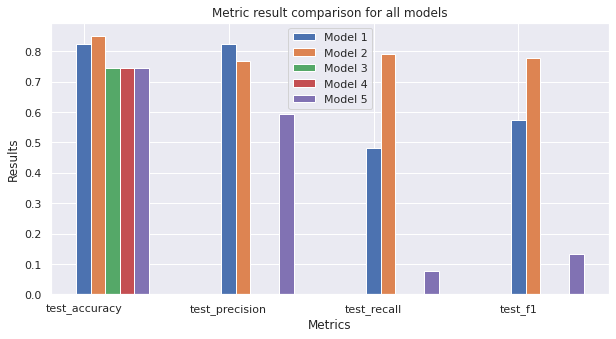

In [28]:
#Plotting results from each model input
interestData = modelResults.drop(['model', 'fit_time', 'score_time', 'features'], axis=1)
XResultsAxis = np.arange(len(interestData.columns))
interestData = interestData.transpose()

fig, axs = plt.subplots(1,1)
fig.set_figwidth(10)
fig.set_figheight(5)

for idx, x in enumerate(modelResults['model']):
    axis = axs.bar(XResultsAxis + idx/(len(interestData.columns) * 2), interestData[idx].values, width= 1/(len(interestData.columns) * 2), label='Model %i' % (idx + 1))
    
axs.set_xticks(XResultsAxis)
axs.set_xticklabels(results.drop(['model', 'fit_time', 'score_time', 'features'], axis=1).columns)
axs.set_xlabel('Metrics')
axs.set_ylabel('Results')
axs.set_title('Metric result comparison for all models')
axs.legend()
plt.show()